In [1]:
import pandas as pd
import pandas_profiling as ppf
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
from datetime import datetime 
import numpy as np
import os, random, math, time
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

#score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

#modeling
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.evaluate import PredefinedHoldoutSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz



# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
def read_file(filename):
    df = pd.read_csv(f'{filename}', encoding="utf-8") #"cp949"
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def read_file2(filename):
    df = pd.read_excel(f'{filename}', header=None)
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

In [3]:
survey_data = read_file('../Data/surveydata_md2.csv')

...There are no duplicates
shape: (160, 103)


In [4]:
survey_data.isnull().sum().any()

False

# 1. 추가 전처리

아침식전_복용 ~ 취침전_복용의 경우 약_복용알람으로 합치자.

In [5]:
survey_data['약_복용알람'] = survey_data['아침식전_복용'] + survey_data['아침식후_복용'] + survey_data['점심식전_복용'] + survey_data['점심식후_복용'] + survey_data['저녁식전_복용'] + survey_data['저녁식후_복용'] + survey_data['취침전_복용']

필요한 컬럼 선정

In [6]:
regression_data = survey_data[['sex', '종교', '기상', '아침', '점심', '저녁', '취침',
                              '약_복용알람', '환기', '산책', '당뇨', '고지혈',
                              '고혈압', '수급여부', '제공서비스','age',
                               '치매', '우울증', '만성복약', '고립', '거동불편', '소리반응', '인형관심',
                               '모니터링', '건강관심', '주택타입', '배우자', '자녀수',
                               '청결', '식사', '공공방문', 'doll_score',
                              '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약',
                               '신경과수면제_약', 'med_count', 'stroke', 'hand_hold_sum', 'knock',
                               'human_detection', 'gymnastics', 'brain_timer', 'drug_consume','drug_consume_rt',
                               'psy_before','psy_after']]

In [7]:
regression_data = pd.get_dummies(data = regression_data, drop_first = True)

In [8]:
regression_data.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '환기', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '만성복약', '고립', '거동불편', '소리반응', '인형관심',
       '모니터링', '건강관심', '주택타입', '배우자', '자녀수', '식사', '공공방문', 'doll_score',
       '치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약', '신경과수면제_약',
       'med_count', 'stroke', 'hand_hold_sum', 'knock', 'human_detection',
       'gymnastics', 'brain_timer', 'drug_consume', 'drug_consume_rt',
       'psy_before', 'psy_after', 'sex_여', '종교_무교', '종교_불교', '종교_천주교',
       '수급여부_차상위', '청결_중', '청결_하'],
      dtype='object')

column 추가 제거: 기준은 Feature Selection ipynb에 있음

In [9]:
regression_data.drop(['환기', '만성복약', '소리반응', '인형관심', '모니터링', '배우자'], axis = 1, inplace = True)

약을 먹는데 병에 반영이 안 된 사람들 반영

In [10]:
regression_data.loc[:,'당뇨'][(regression_data['당뇨']==0) & (regression_data['당뇨_약']==1)] = 1
regression_data.loc[:,'우울증'][(regression_data['우울증']==0) & (regression_data['우울증_약']==1)] = 1
regression_data.loc[:,'고지혈'][(regression_data['고지혈']==0) & (regression_data['고지혈증_약']==1)] = 1
regression_data.loc[:,'치매'][(regression_data['치매']==0) & (regression_data['치매_약']==1)] = 1

약 지우기

In [11]:
regression_data.drop(['치매_약', '뇌졸증_약', '혈압_약', '우울증_약', '고지혈증_약', '당뇨_약', '신경과수면제_약'], axis = 1, inplace = True)

종교 지우기

In [12]:
regression_data.drop(['종교_불교', '종교_천주교'], axis = 1, inplace = True)

## Train/Test Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
#긍정변화 여부
Y3 = survey_data['slife_change']>0
Y3.replace([True, False], [1,0], inplace = True)

In [15]:
X = regression_data

In [16]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 123, stratify = Y3)

In [17]:
X_train['고립'].value_counts()

0    115
1     13
Name: 고립, dtype: int64

In [18]:
X_train['건강관심'].value_counts()

0    118
1     10
Name: 건강관심, dtype: int64

In [19]:
X_train['청결_하'].value_counts()

0    109
1     19
Name: 청결_하, dtype: int64

### *Numeric Data Scaling

기상, 아침, 점심, 저녁, 취침, 약 복용알람, age, 자녀수, doll_score, med_count, stroke, hand_hold_sum, knock, human_detection, gymnastics, brain_timer, drug_consume, psy_before, psy_after

In [20]:
numeric_columns = ['기상', '아침', '점심', '저녁', '취침', '약_복용알람', 'age', '자녀수', 'doll_score', 'med_count', 'stroke',
                   'hand_hold_sum', 'knock', 'human_detection', 'gymnastics', 'brain_timer', 'drug_consume','psy_before', 'psy_after']

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
min_max_scaler = MinMaxScaler()

#train, test scaling
X_train[numeric_columns] = min_max_scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = min_max_scaler.transform(X_test[numeric_columns])

### Y data split

In [23]:
#원점수
Y1 = survey_data.loc[:,'slife_after']
Y1_train = survey_data.loc[list(X_train.index.values), 'slife_after']
Y1_test = survey_data.loc[list(X_test.index.values), 'slife_after']

#변화점수
Y2 = survey_data.loc[:, 'slife_change']
Y2_train = survey_data.loc[list(X_train.index.values), 'slife_change']
Y2_test = survey_data.loc[list(X_test.index.values), 'slife_change']

#긍정변화여부
Y3_train = Y3[list(X_train.index.values)]
Y3_test = Y3[list(X_test.index.values)]

## High Correlation 제거

In [24]:
for i, c1 in enumerate (X_train.columns):
    for j, c2 in enumerate (X_train.columns):
        if (i> j )& (abs(X_train.corr().iloc[i,j])>=0.7):
            print(c1," + ",c2, ' : ', np.round(X_train.corr().iloc[i,j],4))

knock  +  stroke  :  0.9009
gymnastics  +  stroke  :  0.7732
gymnastics  +  knock  :  0.7602
brain_timer  +  hand_hold_sum  :  0.8528


In [25]:
X_train.drop(['hand_hold_sum','knock','stroke'], axis = 1, inplace = True)

In [26]:
X = X[X_train.columns]
X_test = X_test[X_train.columns]

In [27]:
for i, c1 in enumerate (X_train.columns):
    for j, c2 in enumerate (X_train.columns):
        if (i> j )& (abs(X_train.corr().iloc[i,j])>=0.7):
            print(c1," + ",c2, ' : ', np.round(X_train.corr().iloc[i,j],4))

# 1. 생활관리 원점수

## 1-1. Linear Regression

In [28]:
import statsmodels.api as sm
X_Sm= sm.add_constant(X_train)
ls=sm.OLS(Y1_train,X_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:            slife_after   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     1.953
Date:                Thu, 09 Dec 2021   Prob (F-statistic):            0.00590
Time:                        20:43:12   Log-Likelihood:                -273.71
No. Observations:                 128   AIC:                             619.4
Df Residuals:                      92   BIC:                             722.1
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              21.8340      3.418     

In [29]:
X_Sm = sm.add_constant(X_train)
Y1_pred = ls.predict(X_Sm)
Y1_pred[Y1_pred > 24] = 24
Y1_pred[Y1_pred < 0] = 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
MAP = mean_absolute_percentage_error(Y1_train, Y1_pred)
print('train_rmse:', rmse)
print('train_map:', MAP)

train_rmse: 2.0532521483203583
train_map: 0.08696284310668206


In [30]:
X_Sm = sm.add_constant(X_test)
Y1_pred = ls.predict(X_Sm)
Y1_pred[Y1_pred > 24] = 24
Y1_pred[Y1_pred < 0] = 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
MAP = mean_absolute_percentage_error(Y1_test, Y1_pred)
print('test_rmse:', rmse)
print('test_map:', MAP)

test_rmse: 3.2948540969735363
test_map: 0.13351924054637743


## 1-2. Lasso CV

In [31]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [32]:
las = LassoCV()
las.fit(X_train, Y1_train)
print("Best alpha using built-in LassoCV: %f" % las.alpha_)
print("Best score using built-in LassoCV: %f" %las.score(X_train,Y1_train))
coef = pd.Series(las.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.108853
Best score using built-in LassoCV: 0.209477


In [33]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 10 variables and eliminated the other 25 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

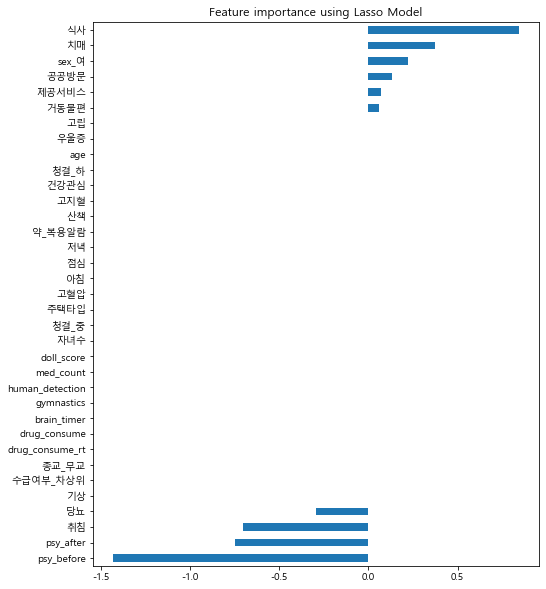

In [34]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [35]:
Y1_pred = las.predict(X_train)
Y1_pred[Y1_pred > 24] = 24
Y1_pred[Y1_pred < 0] = 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 2.410071766020981


In [36]:
Y1_pred = las.predict(X_test)
Y1_pred[Y1_pred > 24] = 24
Y1_pred[Y1_pred < 0] = 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 2.7610077835070754


## 1-3. Ridge CV

In [37]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

In [38]:
rid = RidgeCV()
rid.fit(X_train, Y1_train)
print("Best alpha using built-in RidgeCV: %f" % rid.alpha_)
print("Best score using built-in RidgeCV: %f" % rid.score(X_train,Y1_train))
coef = pd.Series(rid.coef_, index = X_train.columns)

Best alpha using built-in RidgeCV: 10.000000
Best score using built-in RidgeCV: 0.318716


Text(0.5, 1.0, 'Feature importance using Ridge Model')

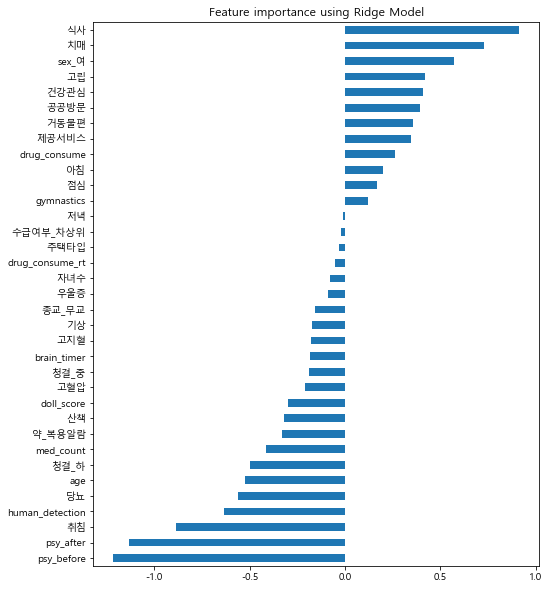

In [39]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")

In [40]:
Y1_pred = rid.predict(X_train)
Y1_pred[Y1_pred > 24] = 24
Y1_pred[Y1_pred < 0] = 0
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 2.2373649806616513


In [41]:
Y1_pred = rid.predict(X_test)
Y1_pred[Y1_pred > 24] = 24
Y1_pred[Y1_pred < 0] = 0
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 3.033822072955456


## 1-4. Linear Mixed Model

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [43]:
X_train.columns

Index(['기상', '아침', '점심', '저녁', '취침', '약_복용알람', '산책', '당뇨', '고지혈', '고혈압',
       '제공서비스', 'age', '치매', '우울증', '고립', '거동불편', '건강관심', '주택타입', '자녀수', '식사',
       '공공방문', 'doll_score', 'med_count', 'human_detection', 'gymnastics',
       'brain_timer', 'drug_consume', 'drug_consume_rt', 'psy_before',
       'psy_after', 'sex_여', '종교_무교', '수급여부_차상위', '청결_중', '청결_하'],
      dtype='object')

In [44]:
#doll_id 기준 group
X2 = pd.concat([X_train, survey_data['doll_id'][survey_data.index.isin(X_train.index)]], axis = 1)
X2 = pd.concat([X2, Y1_train], axis = 1)

In [45]:
#기관 기준 group
X3 = pd.concat([X_train, survey_data['기관2'][survey_data.index.isin(X_train.index)]], axis = 1)
X3 = pd.concat([X3, Y1_train], axis = 1)

In [46]:
#psy_before_cat 기준 group
X4 = pd.concat([X_train, survey_data['psy_before_cat'][survey_data.index.isin(X_train.index)]], axis = 1)
X4 = pd.concat([X4, Y1_train], axis =1)

### 1) doll_id 기준 group

In [47]:
doll_formula = 'slife_after ~ '
for i,j in enumerate(X2.drop(['doll_id','slife_after'], axis = 1).columns):
    if i==0:
        doll_formula += j
    else:
        doll_formula += '+' + j

In [48]:
doll_formula

'slife_after ~ 기상+아침+점심+저녁+취침+약_복용알람+산책+당뇨+고지혈+고혈압+제공서비스+age+치매+우울증+고립+거동불편+건강관심+주택타입+자녀수+식사+공공방문+doll_score+med_count+human_detection+gymnastics+brain_timer+drug_consume+drug_consume_rt+psy_before+psy_after+sex_여+종교_무교+수급여부_차상위+청결_중+청결_하'

In [49]:
doll_md = smf.mixedlm(formula = doll_formula, data = X2, groups = X2['doll_id'])

In [50]:
doll_mdf = doll_md.fit()
print(doll_mdf.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: slife_after
No. Observations:   128     Method:             REML       
No. Groups:         128     Scale:              2.9328     
Min. group size:    1       Log-Likelihood:     -251.3936  
Max. group size:    1       Converged:          Yes        
Mean group size:    1.0                                    
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
Intercept       21.834    2.396  9.114 0.000  17.138 26.530
기상              -0.727    2.487 -0.292 0.770  -5.602  4.149
아침               1.496    2.175  0.688 0.492  -2.768  5.760
점심               2.565    1.262  2.033 0.042   0.092  5.038
저녁              -0.062    1.890 -0.033 0.974  -3.766  3.642
취침              -1.239    0.690 -1.797 0.072  -2.590  0.113
약_복용알람          -0.071    1.590 -0.045 0.964  -3.18

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [51]:
doll_pred = doll_mdf.predict(X2.iloc[:,:-2])
rms = sqrt(mean_squared_error(Y1_train, doll_pred))
rms

3.1773398852832946

그냥 ls 때랑 똑같네?

### 2) 기관 기준 group

In [52]:
기관_formula = 'slife_after ~ '
for i,j in enumerate(X3.drop(['기관2','slife_after'], axis = 1).columns):
    if i==0:
        기관_formula += j
    else:
        기관_formula += '+' + j

In [53]:
기관_formula

'slife_after ~ 기상+아침+점심+저녁+취침+약_복용알람+산책+당뇨+고지혈+고혈압+제공서비스+age+치매+우울증+고립+거동불편+건강관심+주택타입+자녀수+식사+공공방문+doll_score+med_count+human_detection+gymnastics+brain_timer+drug_consume+drug_consume_rt+psy_before+psy_after+sex_여+종교_무교+수급여부_차상위+청결_중+청결_하'

In [54]:
기관_md = smf.mixedlm(formula = 기관_formula, data = X3, groups = X3['기관2'])
기관_mdf = 기관_md.fit()
print(기관_mdf.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: slife_after
No. Observations:   128     Method:             REML       
No. Groups:         7       Scale:              5.4678     
Min. group size:    2       Log-Likelihood:     -250.7316  
Max. group size:    43      Converged:          No         
Mean group size:    18.3                                   
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
Intercept       21.474    3.398  6.320 0.000  14.814 28.134
기상              -1.277    2.540 -0.503 0.615  -6.255  3.701
아침               2.567    2.579  0.996 0.319  -2.487  7.621
점심               2.820    2.341  1.205 0.228  -1.768  7.408
저녁              -0.363    2.121 -0.171 0.864  -4.520  3.794
취침              -1.194    0.680 -1.755 0.079  -2.528  0.140
약_복용알람          -0.189    1.550 -0.122 0.903  -3.22

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.427233
  warnings.warn(msg, ConvergenceWarning)


In [55]:
기관_pred = 기관_mdf.predict(X3.iloc[:,:-2])
rms = sqrt(mean_squared_error(Y1_train, 기관_pred))
rms

3.2098194892258363

### 3) psy_before_cat 기준 group

In [56]:
psy_formula = 'slife_after ~ '
for i,j in enumerate(X4.drop(['psy_before_cat','slife_after'], axis = 1).columns):
    if i==0:
        psy_formula += j
    else:
        psy_formula += '+' + j

In [57]:
psy_formula

'slife_after ~ 기상+아침+점심+저녁+취침+약_복용알람+산책+당뇨+고지혈+고혈압+제공서비스+age+치매+우울증+고립+거동불편+건강관심+주택타입+자녀수+식사+공공방문+doll_score+med_count+human_detection+gymnastics+brain_timer+drug_consume+drug_consume_rt+psy_before+psy_after+sex_여+종교_무교+수급여부_차상위+청결_중+청결_하'

In [58]:
psy_md = smf.mixedlm(formula = psy_formula, data = X4, re_formula = '~psy_before', groups = X4['psy_before_cat'])
psy_mdf = psy_md.fit()
print(psy_mdf.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    slife_after
No. Observations:    128        Method:                REML       
No. Groups:          2          Scale:                 5.8650     
Min. group size:     14         Log-Likelihood:        -251.6628  
Max. group size:     114        Converged:             No         
Mean group size:     64.0                                         
------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------
Intercept              21.897                                     
기상                     -0.729    2.540 -0.287 0.774  -5.707  4.250
아침                      1.491    2.457  0.607 0.544  -3.324  6.306
점심                      2.571    2.242  1.147 0.251  -1.823  6.964
저녁                     -0.059    1.292 -0.046 0.964  -2.592  2.474
취침        

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.513958
  warnings.warn(msg, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [59]:
psy_pred = psy_mdf.predict(X4.iloc[:,:-2])
rms = sqrt(mean_squared_error(Y1_train, psy_pred))
rms

3.1824588503865967

## 1-5. SFS (Linear Regression)

### Forward

In [60]:
ols = LinearRegression()
sfs_forward = SFS(estimator=ols, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=True, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_forward.fit(X_train, Y1_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [61]:
selected_variables = list(sfs_forward.k_feature_names_)
selected_variables

['제공서비스', '고립', '식사', '공공방문', 'psy_before', 'psy_after']

In [62]:
print('best average cv_score:',sfs_forward.k_score_)

best average cv_score: -2.4197658034718774


In [63]:
ols.fit(X_train[selected_variables], Y1_train)
Y1_pred = ols.predict(X_train[selected_variables])
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 2.3448571818294583


In [64]:
Y1_pred = ols.predict(X_test[selected_variables])
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 2.326203512333392


### Backward

In [65]:
ols = LinearRegression()
sfs_backward = SFS(estimator=ols, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=False, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_backward.fit(X_train, Y1_train)

SequentialFeatureSelector(estimator=LinearRegression(), forward=False,
                          k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [66]:
selected_variables = list(sfs_backward.k_feature_names_)
selected_variables

['취침',
 '산책',
 '당뇨',
 'age',
 '치매',
 '식사',
 'doll_score',
 'human_detection',
 'psy_before',
 'psy_after',
 '종교_무교']

In [67]:
print('best average cv_score:',sfs_backward.k_score_)

best average cv_score: -2.4360265107479213


In [68]:
ols.fit(X_train[selected_variables], Y1_train)
Y1_pred = ols.predict(X_train[selected_variables])
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:',rmse)

train_rmse: 2.199062900741274


In [69]:
Y1_pred = ols.predict(X_test[selected_variables])
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:',rmse)

test_rmse: 2.9117699149349714


## 1-6. Decision Tree

In [70]:
randomseed = 1234

In [71]:
dtree = DecisionTreeRegressor(random_state=randomseed, min_samples_leaf=4)
dtree.fit(X_train, Y1_train)

DecisionTreeRegressor(min_samples_leaf=4, random_state=1234)

In [72]:
Y1_pred = dtree.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 1.3473546613024106


In [73]:
Y1_pred = dtree.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 3.9020134055100386


## 1-7. Random Forest

In [74]:
randomseed = 1234

In [75]:
rforest = RandomForestRegressor(random_state = randomseed, min_samples_leaf=5)
rforest.fit(X_train, Y1_train)

RandomForestRegressor(min_samples_leaf=5, random_state=1234)

In [76]:
Y1_pred = rforest.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 1.647855826920543


In [77]:
Y1_pred = rforest.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 2.633076887295945


## 1-8. XGBoost

In [78]:
randomseed = 1234

In [79]:
xgb = XGBRegressor(random_state = randomseed, max_depth = 5)
xgb.fit(X_train, Y1_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [80]:
Y1_pred = xgb.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 0.0009013892287417399


In [81]:
Y1_pred = xgb.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 3.1369704987506513


## 1-9. LGBM

In [82]:
randomseed = 1234

In [83]:
lgbm = LGBMRegressor(random_state = randomseed, max_depth = 5)
lgbm.fit(X_train, Y1_train)

LGBMRegressor(max_depth=5, random_state=1234)

In [84]:
Y1_pred = lgbm.predict(X_train)
rmse = sqrt(mean_squared_error(Y1_train, Y1_pred))
print('train_rmse:', rmse)

train_rmse: 1.1574362014012574


In [85]:
Y1_pred = lgbm.predict(X_test)
rmse = sqrt(mean_squared_error(Y1_test, Y1_pred))
print('test_rmse:', rmse)

test_rmse: 2.7444638205362075


# 2. 생활관리 Change

## 2-1. Linear Regression

In [86]:
import statsmodels.api as sm
X_Sm= sm.add_constant(X_train)
ls=sm.OLS(Y2_train,X_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:           slife_change   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.9401
Date:                Thu, 09 Dec 2021   Prob (F-statistic):              0.570
Time:                        20:43:27   Log-Likelihood:                -301.12
No. Observations:                 128   AIC:                             674.2
Df Residuals:                      92   BIC:                             776.9
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.4608      4.234     

In [87]:
X_Sm = sm.add_constant(X_train)
Y2_pred = ls.predict(X_Sm)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 2.543455088126127


In [88]:
X_Sm = sm.add_constant(X_test)
Y2_pred = ls.predict(X_Sm)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 3.2113252355690913


## 2-2. Lasso CV

In [89]:
las = LassoCV()
las.fit(X_train, Y2_train)
print("Best alpha using built-in LassoCV: %f" % las.alpha_)
print("Best score using built-in LassoCV: %f" %las.score(X_train,Y2_train))
coef = pd.Series(las.coef_, index = X_train.columns)

Best alpha using built-in LassoCV: 0.208862
Best score using built-in LassoCV: 0.000000


In [90]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 0 variables and eliminated the other 35 variables


## 2-3. Ridge CV

In [91]:
rid = RidgeCV()
rid.fit(X_train, Y2_train)
print("Best alpha using built-in RidgeCV: %f" % rid.alpha_)
print("Best score using built-in RidgeCV: %f" % rid.score(X_train,Y2_train))
coef = pd.Series(las.coef_, index = X_train.columns)

Best alpha using built-in RidgeCV: 10.000000
Best score using built-in RidgeCV: 0.188604


In [92]:
Y2_pred = rid.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.669541900807158


In [93]:
Y2_pred = rid.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.5703874312310884


## 2-4. SFS (Linear Regression)

### Forward

In [94]:
ols = LinearRegression()
sfs_forward = SFS(estimator=LinearRegression(), 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=True, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_forward.fit(X_train, Y2_train)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [95]:
selected_variables = list(sfs_forward.k_feature_names_)
selected_variables

['아침', '산책', '제공서비스', '건강관심', '주택타입', '자녀수', '식사', '청결_중', '청결_하']

In [96]:
print('best average cv_score:',sfs_forward.k_score_)

best average cv_score: -2.847323249087282


In [97]:
ols.fit(X_train[selected_variables], Y2_train)
Y2_pred = ols.predict(X_train[selected_variables])
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.7249163342916543


In [98]:
Y2_pred = ols.predict(X_test[selected_variables])
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:',rmse)

test_rmse: 2.7454808279371044


### Backward

In [99]:
ols = LinearRegression()
sfs_backward = SFS(estimator=ols, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=False, 
           floating=False, 
           scoring='neg_root_mean_squared_error', cv = 5)

sfs_backward.fit(X_train, Y2_train)

SequentialFeatureSelector(estimator=LinearRegression(), forward=False,
                          k_features=(5, 15),
                          scoring='neg_root_mean_squared_error')

In [100]:
selected_variables = list(sfs_backward.k_feature_names_)
selected_variables

['취침',
 '산책',
 '당뇨',
 '제공서비스',
 'age',
 '건강관심',
 '주택타입',
 'human_detection',
 'gymnastics',
 'brain_timer',
 'drug_consume',
 '청결_중',
 '청결_하']

In [101]:
print('best average cv_score:',sfs_backward.k_score_)

best average cv_score: -2.8965888026695588


In [102]:
ols.fit(X_train[selected_variables], Y2_train)
Y2_pred = ols.predict(X_train[selected_variables])
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:',rmse)

train_rmse: 2.645765824412337


In [103]:
Y2_pred = ols.predict(X_test[selected_variables])
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:',rmse)

test_rmse: 2.8352039589265936


## 2-5. Decision Tree

In [104]:
randomseed = 1234

In [105]:
dtree = DecisionTreeRegressor(random_state=randomseed, min_samples_leaf=5)
dtree.fit(X_train, Y2_train)

DecisionTreeRegressor(min_samples_leaf=5, random_state=1234)

In [106]:
Y2_pred = dtree.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 1.854397390674308


In [107]:
Y2_pred = dtree.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 3.256368132389708


## 2-6. Random Forest

In [108]:
randomseed = 1234

In [109]:
rforest = RandomForestRegressor(random_state = randomseed, min_samples_leaf=5)
rforest.fit(X_train, Y2_train)

RandomForestRegressor(min_samples_leaf=5, random_state=1234)

In [110]:
Y2_pred = rforest.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 1.9928873578583746


In [111]:
Y2_pred = rforest.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 2.7735971918002433


## 2-7. XGBoost

In [112]:
randomseed = 1234

In [113]:
xgb = XGBRegressor(random_state = randomseed, max_depth = 5)
xgb.fit(X_train, Y2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [114]:
Y2_pred = xgb.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 0.0010183446392657788


In [115]:
Y2_pred = xgb.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 2.6246059650851663


## 2-8. LightGBM

In [116]:
randomseed = 1234

In [117]:
lgbm = LGBMRegressor(random_state = randomseed, max_depth = 5)
lgbm.fit(X_train, Y2_train)

LGBMRegressor(max_depth=5, random_state=1234)

In [118]:
Y2_pred = lgbm.predict(X_train)
rmse = sqrt(mean_squared_error(Y2_train, Y2_pred))
print('train_rmse:', rmse)

train_rmse: 1.4161290036182694


In [119]:
Y2_pred = lgbm.predict(X_test)
rmse = sqrt(mean_squared_error(Y2_test, Y2_pred))
print('test_rmse:', rmse)

test_rmse: 3.6658538539298084


# 3. 긍정변화여부

## 3-1. Logistic Regression

In [120]:
X_Sm= sm.add_constant(X_train)
logit=sm.Logit(Y3_train,X_Sm).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.541931
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           slife_change   No. Observations:                  128
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                           35
Date:                Thu, 09 Dec 2021   Pseudo R-squ.:                  0.2113
Time:                        20:43:38   Log-Likelihood:                -69.367
converged:                       True   LL-Null:                       -87.956
Covariance Type:            nonrobust   LLR p-value:                    0.3690
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.6875      3.937      0.937      0.349      -4.030      11.405
기상            

In [121]:
logit = LogisticRegression()
logit.fit(X_train, Y3_train)
Y3_pred = logit.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:',accu)

train_accuracy: 0.6796875


In [122]:
Y3_pred = logit.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.6875


## 3-2. SFS

### Forward

In [123]:
logit = LogisticRegression()
sfs_forward = SFS(estimator=logit, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=True, 
           floating=False, 
           scoring='accuracy', cv = 5)

sfs_forward.fit(X_train, Y3_train)

SequentialFeatureSelector(estimator=LogisticRegression(), k_features=(5, 15),
                          scoring='accuracy')

In [124]:
selected_variables = list(sfs_forward.k_feature_names_)
selected_variables

['산책',
 '제공서비스',
 'age',
 'doll_score',
 'human_detection',
 'gymnastics',
 'brain_timer',
 '수급여부_차상위']

In [125]:
print('best average cv_score:',sfs_forward.k_score_)

best average cv_score: 0.6575384615384616


In [126]:
logit = LogisticRegression()
logit.fit(X_train[selected_variables], Y3_train)
Y3_pred = logit.predict(X_train[selected_variables])
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:',accu)

train_accuracy: 0.65625


In [127]:
Y3_pred = logit.predict(X_test[selected_variables])
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:',accu)

test_accuracy: 0.53125


### Backward

In [128]:
logit = LogisticRegression()
sfs_backward = SFS(estimator=logit, 
           k_features=(5, 15), #feature의 개수를 최소 몇 개 이상 최대 몇 개 이하로 하고 싶은지.
           forward=False, 
           floating=False, 
           scoring='accuracy', cv = 5)

sfs_backward.fit(X_train, Y3_train)

SequentialFeatureSelector(estimator=LogisticRegression(), forward=False,
                          k_features=(5, 15), scoring='accuracy')

In [129]:
selected_variables = list(sfs_backward.k_feature_names_)
selected_variables

['기상',
 '산책',
 '고지혈',
 '제공서비스',
 'age',
 '우울증',
 '거동불편',
 '주택타입',
 '식사',
 'human_detection',
 'drug_consume',
 'sex_여',
 '수급여부_차상위',
 '청결_중',
 '청결_하']

In [130]:
print('best average cv_score:',sfs_backward.k_score_)

best average cv_score: 0.664


In [131]:
logit = LogisticRegression()
logit.fit(X_train[selected_variables], Y3_train)
Y3_pred = logit.predict(X_train[selected_variables])
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.671875


In [132]:
Y3_pred = logit.predict(X_test[selected_variables])
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.625


## 3-3. Decision Tree

In [133]:
randomseed = 333

In [134]:
#selected_variables = ['저녁', '산책', 'age', '우울증', '거동불편', '자녀수', '식사', '공공방문', 'gymnastics', 'psy_before', '수급여부_차상위']

In [135]:
dtree = DecisionTreeClassifier(random_state=randomseed, min_samples_leaf=10)
dtree.fit(X_train, Y3_train)

DecisionTreeClassifier(min_samples_leaf=10, random_state=333)

In [136]:
Y3_pred = dtree.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.734375


In [137]:
Y3_pred = dtree.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.625


## 3-4. RandomForest

In [138]:
randomseed = 333

In [139]:
rforest = RandomForestClassifier(random_state=randomseed, min_samples_leaf=7, criterion = 'entropy')
rforest.fit(X_train, Y3_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=7,
                       random_state=333)

In [140]:
Y3_pred = rforest.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.8671875


In [141]:
Y3_pred = rforest.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.6875


## 3-5. XGBoost

In [142]:
randomseed = 333

In [143]:
xgb = XGBClassifier(random_state=randomseed, learning_rate = 0.01, max_depth = 5, gamma=1, base_score = 0.7)
xgb.fit(X_train, Y3_train)

[20:44:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.7, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=333,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
Y3_pred = xgb.predict(X_train)
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.828125


In [145]:
Y3_pred = xgb.predict(X_test)
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.65625


## 3-6. LGBM

In [146]:
randomseed = 1234

In [147]:
lgbm = LGBMClassifier(random_state=randomseed, learning_rate = 0.01, max_depth = 5, min_child_samples=5, num_leaves=9)
lgbm.fit(X_train, Y3_train)

LGBMClassifier(learning_rate=0.01, max_depth=5, min_child_samples=5,
               num_leaves=9, random_state=1234)

In [148]:
Y3_pred = lgbm.predict_proba(X_train)
Y3_pred = Y3_pred[:,1] > 0.55
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.953125


In [149]:
confusion_matrix(Y3_train, Y3_pred)

array([[54,  3],
       [ 3, 68]], dtype=int64)

In [150]:
Y3_pred = lgbm.predict_proba(X_test)
Y3_pred = Y3_pred[:,1] > 0.5
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.75


In [151]:
confusion_matrix(Y3_test, Y3_pred)

array([[ 8,  6],
       [ 2, 16]], dtype=int64)

In [152]:
pd.crosstab(Y3_test, Y3_pred)

col_0,False,True
slife_change,,
0,8,6
1,2,16


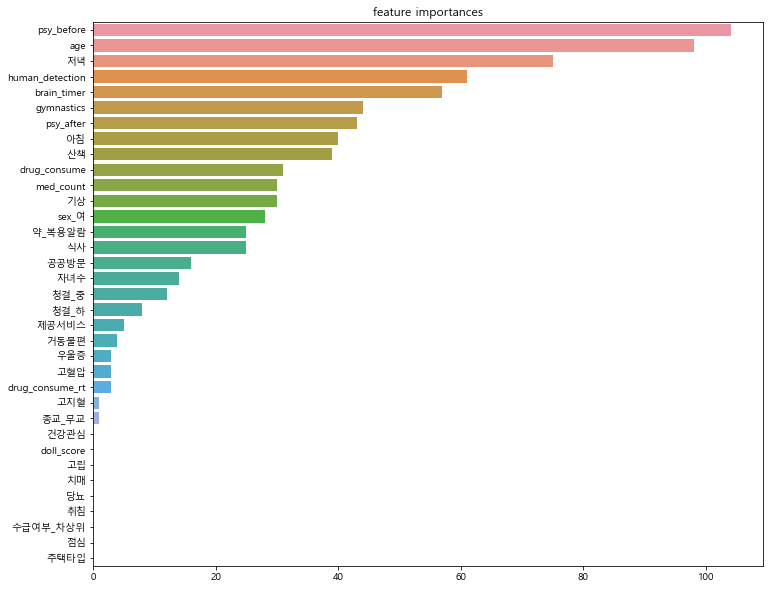

In [153]:
ft_importances = pd.Series(lgbm.feature_importances_, index = X_train.columns)
ft_importances = ft_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
plt.title("feature importances")
sns.barplot(x=ft_importances, y = ft_importances.index)
plt.show()

In [154]:
selected_variables = X_train.columns[lgbm.feature_importances_!=0]

In [155]:
lgbm = LGBMClassifier(random_state=randomseed, learning_rate = 0.01, max_depth = 5, min_child_samples=5, num_leaves=9)
lgbm.fit(X_train[selected_variables], Y3_train)

LGBMClassifier(learning_rate=0.01, max_depth=5, min_child_samples=5,
               num_leaves=9, random_state=1234)

In [156]:
Y3_pred = lgbm.predict(X_train[selected_variables])
accu = accuracy_score(Y3_train, Y3_pred)
print('train_accuracy:', accu)

train_accuracy: 0.9375


In [157]:
Y3_pred = lgbm.predict_proba(X_test[selected_variables])
Y3_pred = Y3_pred[:,1] > 0.5
accu = accuracy_score(Y3_test, Y3_pred)
print('test_accuracy:', accu)

test_accuracy: 0.75


# SHAP

In [158]:
X_train_selected = X_train[selected_variables]
X_test_selected = X_test[selected_variables]

In [159]:
import shap

In [160]:
lgbm = LGBMClassifier(random_state=randomseed, learning_rate = 0.01, max_depth = 5, min_child_samples=5, num_leaves=9)
lgbm.fit(X_train_selected, Y3_train)

LGBMClassifier(learning_rate=0.01, max_depth=5, min_child_samples=5,
               num_leaves=9, random_state=1234)

In [161]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train_selected)

## Summary Plot

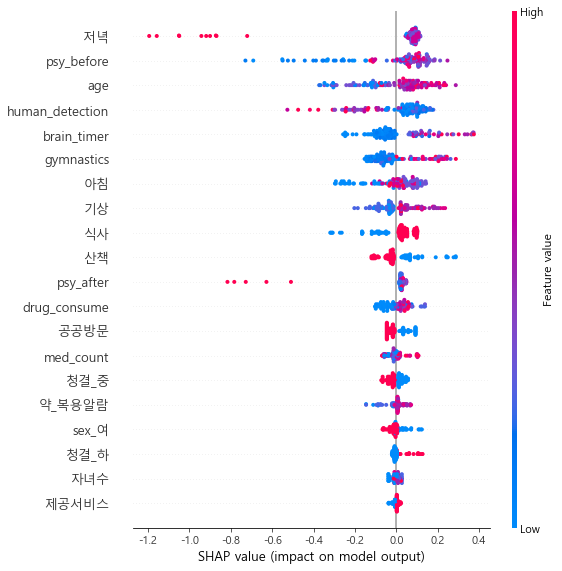

In [177]:
shap.summary_plot(shap_values[1], X_train_selected)

저녁의 값이 높은 것은 부정적인 영향을 끼친다.

psy_before의 값이 낮은 것은 부정적인 영향을 미친다.

이런식으로 해석

## Individual force plot

In [163]:
shap.initjs()

In [164]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train_selected.iloc[0,:], link = 'logit')

Training Dataset에서 첫 번째 유저에 대한 각 변수의 영향을 나타낸다.

우선 우리 LGBM 모델의 첫 번째 유저에 대한 결과는 다음과 같다.

In [165]:
print('predict 결과:{}'.format(lgbm.predict(X_train_selected)[0]))
print('1일 확률:{}'.format(lgbm.predict_proba(X_train_selected)[0][1]))

predict 결과:0
1일 확률:0.3174877366638073


즉, 우리 모델은 첫 번째 유저가 개선이 되지 않았을 것이라고 예측했는데,

psy_before 값이 가장 큰 영향을 미쳤고, 그 다음으로는 human_detection, 아침, 등등의 값이 부정적인 영향을 미쳤다.

저녁과 age가 그나마 긍정적인 영향을 미쳤지만, 개선으로 예측할만큼의 영향을 주지는 못하였다.

두 번째 인덱스

In [166]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_train_selected.iloc[1,:], link = 'logit')

In [167]:
print('predict 결과:{}'.format(lgbm.predict(X_train_selected)[1]))
print('1일 확률:{}'.format(lgbm.predict_proba(X_train_selected)[1][1]))

predict 결과:1
1일 확률:0.7302987915937094


두 번째 유저에 대해서 LGBM은 개선이 될 것이라고 예측하였는데, 

긍정적으로 가장 큰 영향을 준 것은 gymnastic, age, psy_before 등이고

그나마 brain_timer나 공공방문이 부정적인 영향을 주었다.

## Global force plot

In [168]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_train_selected)

이걸 보고 클러스터링을 할 수 있다고 하는데,, 흠.. 잘 모르겠다.

## Interaction Plot

In [169]:
shap_interaction_values = shap.TreeExplainer(lgbm).shap_interaction_values(X_train_selected)

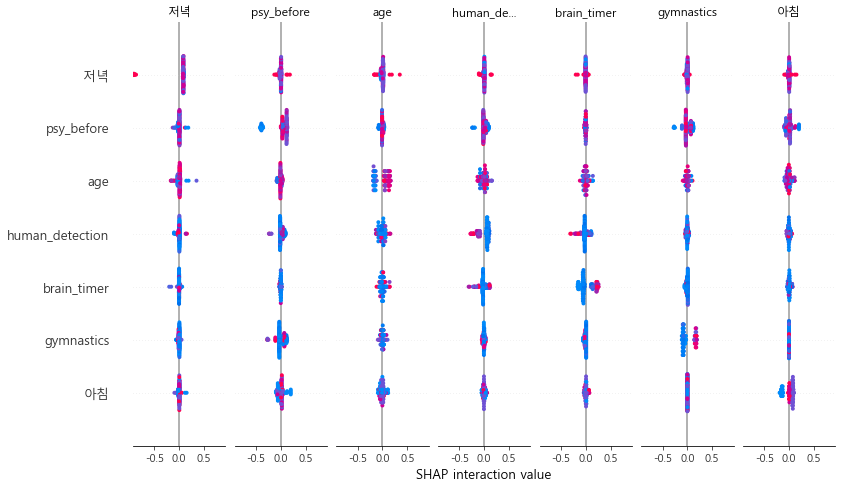

In [170]:
shap.summary_plot(shap_interaction_values, X_train_selected)

잘 모르겠다. interaction 값을 heatmap으로 그려보자.

<Figure size 2160x2160 with 0 Axes>

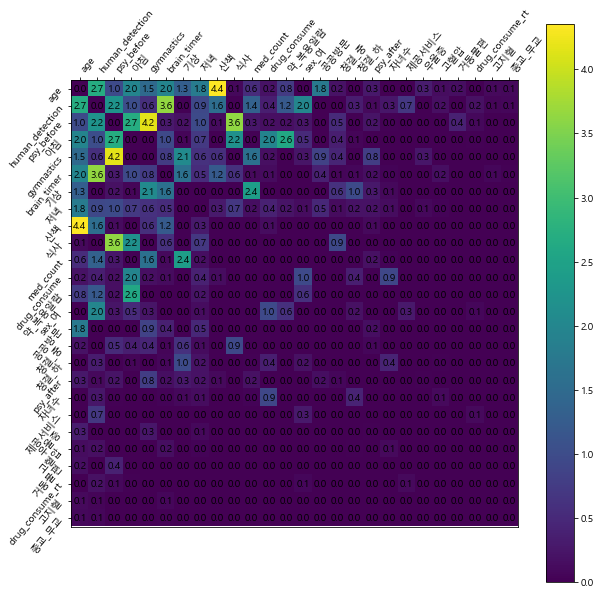

In [171]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
plt.figure(figsize=(30,30))
plt.matshow(tmp2)
plt.yticks(range(tmp2.shape[0]), X_train_selected.columns[inds], rotation=50.4, horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]), X_train_selected.columns[inds], rotation=50.4, horizontalalignment="left")
plt.gca().xaxis.tick_top()
width, height = tmp2.shape

for x in range(width):
    for y in range(height):
        plt.annotate(str(round(tmp2[x][y],1)), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
plt.colorbar()
plt.show()

높은 애들

1) 산책 - age

2) gymnastics - psy_before

3) 식사 - psy_before

4) brain_timer - human detection

## Dependence Plot

참조
1) https://moondol-ai.tistory.com/394  
2) https://slundberg.github.io/shap/notebooks/tree_explainer/Census%20income%20classification%20with%20LightGBM.html

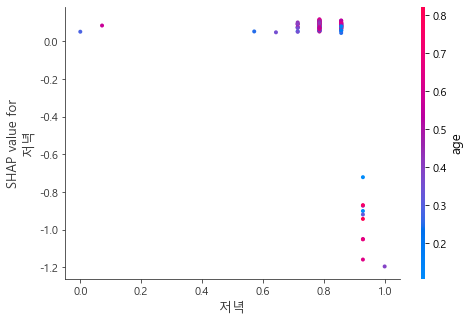

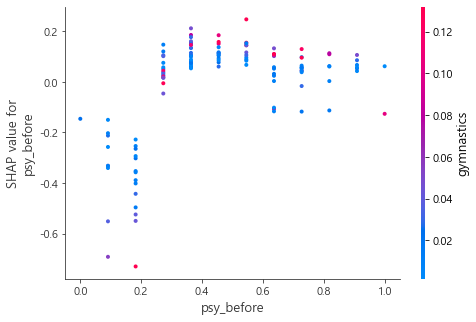

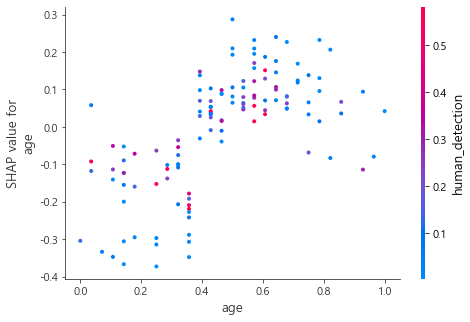

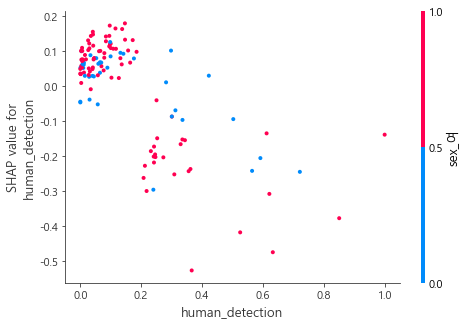

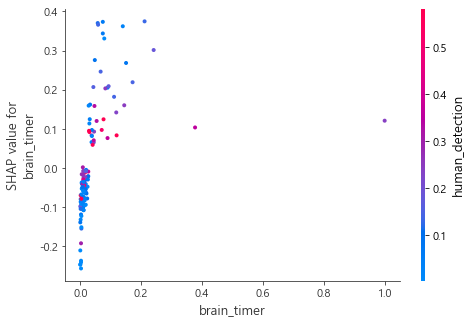

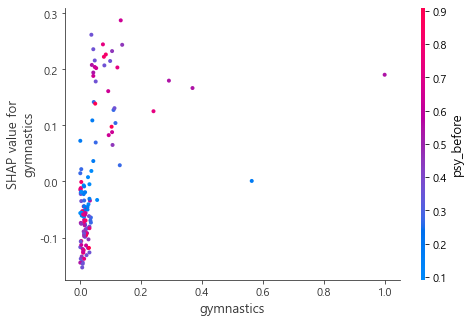

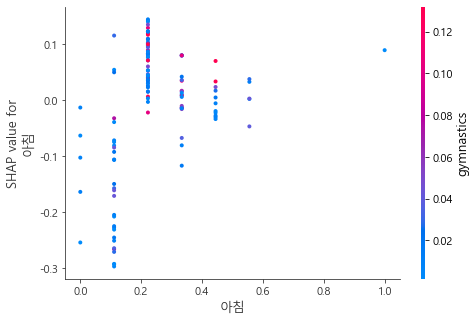

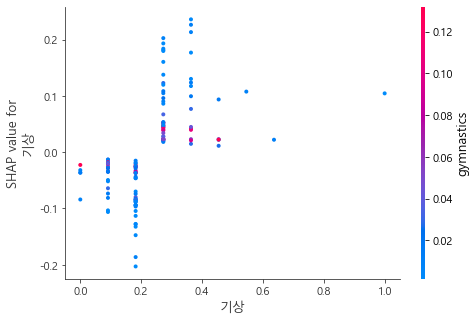

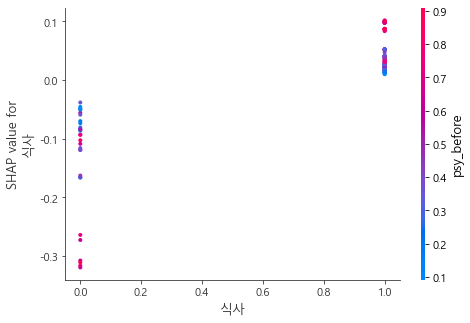

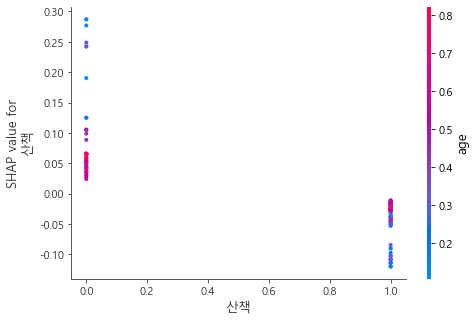

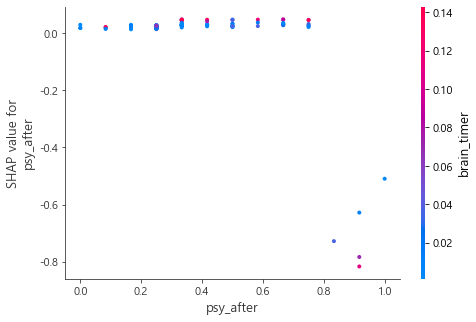

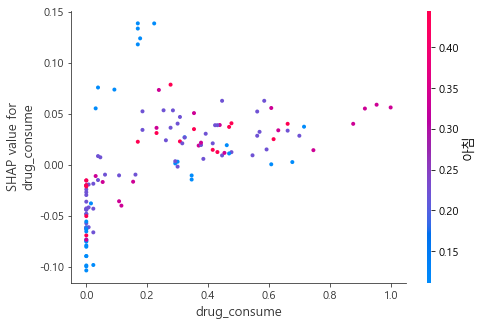

In [172]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[1]), 0))

# 영향력 top 12 컬럼
for i in range(12):
    shap.dependence_plot(top_inds[i], shap_values[1], X_train_selected)

1) 저녁 시간이 너무 늦으면 생활관리 개선에 부정적인 영향을 끼친다.

2) psy_before의 값이 클수록 생활관리 개선에 긍정적인 영향을 끼친다.

3) 나이가 많을수록 생활관리 개선에 긍정적인 영향을 끼친다.

4) human_detection이 높을수록 생활관리 개선에 부정적인 영향을 미친다. (..??)

5) brain_timer를 더 많이 사용했을수록 생활관리 개선에 긍정적인 영향을 미친다.
- 다만 human_detection이 높은 경우 brain_timer가 생활관리 개선에 끼치는 영향이 적다.

6) gymnastics를 더 많이 사용했을수록 생활관리 개선에 긍정적인 영향을 미친다.

7) 아침 먹는 시간이 늦을수록 생활관리 개선에 긍정적인 영향을 미친다.

8) 아침에 일어나는 시간이 늦을수록 생활관리 개선에 긍정적인 영향을 미친다.

9) 식사를 직접하는 상황은 생활관리 개선에 긍정적인 영향을 미친다.
- 다만 psy_before가 낮은 경우에는 식사가 생활관리에 끼치는 영향이 더 낮다.

10) 산책을 하는 경우 생활관리 개선에 부정적인 영향을 미친다.
- 다만 age가 높은 경우 산책이 생활관리에 미치는 영향이 더 낮다.

11) psy_after 값이 높은 경우 생활관리 개선에 부정적인 영향을 미친다.

12) drug_consume을 더 많이 한 경우 생활관리 개선에 긍정적인 영향을 미친다.